## Reinforcement Learning for Bayesian Network Structure Learning: A Deep Q-Network Approach with Hybrid Rewards

## Reproducibility: Config & Seeding


In [1]:
import os, re, json, math, random, itertools, statistics
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import ast

# Try YAML; if unavailable, use a tiny fallback parser.
cfg_path = Path("config.yml")
raw = cfg_path.read_text(encoding="utf-8")

def _to_number_or_str(s: str):
    """Convert a scalar string to int/float if possible, else return stripped string."""
    s = s.strip().strip('"').strip("'")
    # int?
    if re.fullmatch(r"[+-]?\d+", s):
        try: return int(s)
        except: pass
    # float?
    if re.fullmatch(r"[+-]?(?:\d+\.\d*|\.\d+|\d+)(?:[eE][+-]?\d+)?", s):
        try: return float(s)
        except: pass
    return s

try:
    import yaml
    cfg = yaml.safe_load(raw)
except Exception:
    # Minimal YAML (key: value per line; lists like [a, b, 3.5])
    cfg = {}
    for line in raw.splitlines():
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        if ":" not in line:
            continue
        k, v = line.split(":", 1)
        k = k.strip()
        v = v.strip()
        if v.startswith("[") and v.endswith("]"):
            # Try Python evaluation first; fall back to manual splitting
            try:
                parsed = ast.literal_eval(v)
                if isinstance(parsed, (list, tuple)):
                    v = [ _to_number_or_str(str(x)) if isinstance(x, str) else x for x in parsed ]
                else:
                    v = [_to_number_or_str(str(parsed))]
            except Exception:
                parts = [p.strip() for p in v[1:-1].split(",") if p.strip()]
                v = [_to_number_or_str(p) for p in parts]
        else:
            v = _to_number_or_str(v)
        cfg[k] = v

seed = int(cfg.get("seed", 123))
random.seed(seed); np.random.seed(seed)
print("Loaded config:", json.dumps(cfg, indent=2))


Loaded config: {
  "seed": 123,
  "dataset": "asia",
  "n_synth": 1000,
  "train_frac": 0.8,
  "max_indegree": 2,
  "episodes": 60,
  "episode_budget": 20,
  "epsilon_start": 0.8,
  "epsilon_end": 0.1,
  "gamma": 0.95,
  "alpha_lr": 0.4,
  "tile_len": 6,
  "tile_indices": [
    2,
    5
  ],
  "alpha_weight": 1.0,
  "beta_weight": 0.5,
  "ablation_alphas": [
    0.5,
    1.0
  ],
  "ablation_betas": [
    0.0,
    0.5,
    1.0
  ]
}


## Asia BN (ground-truth) & Synthetic Data


In [2]:
# Asia network (8 variables), canonical discrete BN used in literature.
# We'll define: nodes order, ground-truth edges, and CPDs to sample synthetic data if needed.

nodes = ["Asia","Smoke","Tub","Lung","Either","Xray","Bronch","Dysp"]
idx = {v:i for i,v in enumerate(nodes)}

# Ground-truth DAG (edges as (parent, child))
gt_edges = [
    ("Asia","Tub"),
    ("Smoke","Lung"),
    ("Smoke","Bronch"),
    ("Tub","Either"),
    ("Lung","Either"),
    ("Either","Xray"),
    ("Either","Dysp"),
    ("Bronch","Dysp"),
]

def edges_to_adj(edges):
    n=len(nodes); A=np.zeros((n,n),dtype=int)
    for u,v in edges:
        A[idx[u], idx[v]] = 1
    return A

A_gt = edges_to_adj(gt_edges)

# Simple CPDs (binary vars) for Asia (probabilities chosen to be reasonable; for teaching/demo)
# p(Asia=1)=0.01, p(Smoke=1)=0.5, p(Tub=1|Asia), p(Lung=1|Smoke), etc.
cpd = {
    "Asia": np.array([0.99, 0.01]),
    "Smoke": np.array([0.5, 0.5]),
    # Tub depends on Asia
    ("Tub","Asia"): np.array([[0.99,0.95],  # P(Tub=0|Asia=0/1)
                              [0.01,0.05]]),# P(Tub=1|Asia=0/1)
    # Lung depends on Smoke
    ("Lung","Smoke"): np.array([[0.95,0.85],
                                [0.05,0.15]]),
    # Either depends on Tub,Lung (OR-like)
    ("Either","Tub","Lung"): np.array([
        [1.0, 0.0],  # (0,0) -> Either=0/1
        [0.0, 1.0],  # (1,0)
        [0.0, 1.0],  # (0,1)
        [0.0, 1.0],  # (1,1)
    ]),
    # Xray depends on Either
    ("Xray","Either"): np.array([[0.95,0.2],
                                 [0.05,0.8]]),
    # Bronch depends on Smoke
    ("Bronch","Smoke"): np.array([[0.7,0.4],
                                  [0.3,0.6]]),
    # Dysp depends on Either,Bronch (noisy OR-ish)
    ("Dysp","Either","Bronch"): np.array([
        [0.9,0.1],
        [0.4,0.6],
        [0.3,0.7],
        [0.2,0.8],
    ])
}

def sample_asia(n=1000, seed=123):
    rng = np.random.default_rng(seed)
    data = np.zeros((n,len(nodes)), dtype=int)
    for t in range(n):
        # order: exogenous first
        Asia = rng.choice([0,1], p=cpd["Asia"]); data[t,idx["Asia"]]=Asia
        Smoke= rng.choice([0,1], p=cpd["Smoke"]); data[t,idx["Smoke"]]=Smoke
        Tub  = rng.choice([0,1], p=cpd[("Tub","Asia")][:,Asia]); data[t,idx["Tub"]]=Tub
        Lung = rng.choice([0,1], p=cpd[("Lung","Smoke")][:,Smoke]); data[t,idx["Lung"]]=Lung
        Either = 1 if (Tub==1 or Lung==1) else 0
        data[t,idx["Either"]] = Either
        Xray = rng.choice([0,1], p=cpd[("Xray","Either")][:,Either]); data[t,idx["Xray"]]=Xray
        Bronch = rng.choice([0,1], p=cpd[("Bronch","Smoke")][:,Smoke]); data[t,idx["Bronch"]]=Bronch
        # Dysp table index by (Either, Bronch)
        ind = Either*2 + Bronch
        p = cpd[("Dysp","Either","Bronch")][ind]
        Dysp = rng.choice([0,1], p=p); data[t,idx["Dysp"]]=Dysp
    return pd.DataFrame(data, columns=nodes)

if cfg.get("dataset","asia")=="asia":
    N = int(cfg.get("n_synth",1000))
    df = sample_asia(N, seed=seed)
else:
    # simple independent binary features as a fallback synthetic set
    rng = np.random.default_rng(seed)
    df = pd.DataFrame({v: rng.integers(0,2, size=int(cfg.get("n_synth",1000))) for v in nodes})

df.head()


,Asia,Smoke,Tub,Lung,Either,Xray,Bronch,Dysp
0,0,0,0,0,0,0,1,1
1,0,1,0,0,0,0,1,0
2,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0
4,0,1,0,1,1,1,1,1


In [3]:
# ==== DATASETS: registry + helpers ====
from pathlib import Path

class BNDataset:
    def __init__(self, name, nodes, A_gt=None, df=None, meta=None):
        self.name = name
        self.nodes = nodes
        self.A_gt = A_gt
        self.df = df  # pandas DataFrame of binary columns
        self.meta = meta or {}

def load_binary_csv(path: str):
    """Load a CSV with binary {0,1} columns into a DataFrame (str->int)."""
    import pandas as pd
    df = pd.read_csv(path)
    for c in df.columns:
        # coerce common strings to 0/1 if needed
        if df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip().str.lower().map(
                {"0":0,"1":1,"false":0,"true":1,"no":0,"yes":1}
            ).fillna(df[c]).astype(int)
        else:
            df[c] = df[c].astype(int)
    return df

def adj_from_edges(nodes, edges):
    idx = {v:i for i,v in enumerate(nodes)}
    A = np.zeros((len(nodes), len(nodes)), dtype=int)
    for u,v in edges:
        A[idx[u], idx[v]] = 1
    return A

# --- Built-in ASIA from your notebook (reuse your nodes/A_gt and sampler) ---
asia_ds = BNDataset(
    name="ASIA",
    nodes=nodes,            # uses your earlier `nodes`
    A_gt=A_gt,              # uses your earlier `A_gt`
    df=None,                # filled by generator below
    meta=dict(generator="sample_asia")
)

def maybe_make_data_dir():
    Path("data").mkdir(exist_ok=True)

def get_dataset_registry():
    """
    You can drop real benchmark CSVs in ./data:
      - child.csv       (binary columns)
      - insurance.csv
      - alarm.csv
      - sachs.csv
    If present, they are used; otherwise they’re skipped (ASIA always available).
    """
    maybe_make_data_dir()
    reg = []

    # 1) ASIA: synthesize N samples using your generator every run
    reg.append(("ASIA", dict(
        factory=lambda N=500, seed=123: BNDataset(
            name="ASIA",
            nodes=asia_ds.nodes,
            A_gt=asia_ds.A_gt,
            df=pd.DataFrame(sample_asia(N=N, seed=seed), columns=asia_ds.nodes),
            meta=dict(kind="synthetic", N=N)
        )
    )))

    # 2) Child / Insurance / Alarm / Sachs — if CSVs are present, load them.
    # NOTE: If you also have ground-truth DAGs as edge lists, add them here.
    csv_candidates = [
        ("Child",     "child.csv"),
        ("Insurance", "insurance.csv"),
        ("Alarm",     "alarm.csv"),
        ("Sachs",     "sachs.csv"),
    ]
    for name, fname in csv_candidates:
        p = Path("data")/fname
        if p.exists():
            try:
                _df = load_binary_csv(str(p))
                _nodes = list(_df.columns)
                # Ground truth optional: if you have edges_<name>.txt with "u v" per line:
                gt_path = Path("data")/f"edges_{name.lower()}.txt"
                if gt_path.exists():
                    edges = []
                    with open(gt_path) as fh:
                        for line in fh:
                            s=line.strip()
                            if not s: continue
                            u,v = s.split()
                            edges.append((u,v))
                    Agt = adj_from_edges(_nodes, edges)
                else:
                    Agt = None

                reg.append((name, dict(
                    factory=lambda _df=_df, _nodes=_nodes, Agt=Agt: BNDataset(
                        name=name,
                        nodes=_nodes,
                        A_gt=Agt,
                        df=_df.copy(),
                        meta=dict(kind="csv", path=str(p))
                    )
                )))
            except Exception as e:
                print(f"Skipping {name} (CSV load failed):", e)

    return reg

## BN Primitives (DAG ops, in-degree, acyclicity)


In [4]:
def has_cycle(A: np.ndarray) -> bool:
    n=A.shape[0]
    visited=[0]*n; stack=[0]*n
    def dfs(u):
        visited[u]=1; stack[u]=1
        for v in range(n):
            if A[u,v]==1:
                if not visited[v] and dfs(v): return True
                if stack[v]==1: return True
        stack[u]=0
        return False
    for i in range(n):
        if not visited[i]:
            if dfs(i): return True
    return False

def indegree_ok(A, max_k):
    indeg = A.sum(axis=0)
    return np.all(indeg <= max_k)

def legal_add_moves(A, max_k):
    # add u->v if currently 0, u!=v, adding keeps DAG and indegree<=k
    n=A.shape[0]
    moves=[]
    for u in range(n):
        for v in range(n):
            if u==v or A[u,v]==1: continue
            if A[v,u]==1: # reverse exists, still can add (creates 2-cycle) => illegal; skip
                continue
            A2=A.copy(); A2[u,v]=1
            if indegree_ok(A2, max_k) and not has_cycle(A2):
                moves.append(("add",u,v))
    return moves

def legal_delete_moves(A):
    n=A.shape[0]
    return [("del",u,v) for u in range(n) for v in range(n) if A[u,v]==1]

def legal_reverse_moves(A, max_k):
    n=A.shape[0]
    moves=[]
    for u in range(n):
        for v in range(n):
            if A[u,v]==1 and A[v,u]==0:
                A2=A.copy(); A2[u,v]=0; A2[v,u]=1
                if indegree_ok(A2, max_k) and not has_cycle(A2):
                    moves.append(("rev",u,v))
    return moves

def apply_move(A, move):
    op,u,v = move
    B=A.copy()
    if op=="add": B[u,v]=1
    elif op=="del": B[u,v]=0
    elif op=="rev": B[u,v]=0; B[v,u]=1
    return B

# Quick sanity tests
A0 = np.zeros_like(A_gt)
assert not has_cycle(A0)
assert indegree_ok(A0, cfg.get("max_indegree",2))
assert all(len(m)==3 for m in legal_add_moves(A0, cfg.get("max_indegree",2)))


## Parameter Learning (Dirichlet smoothing) & BIC scoring


In [5]:
# We'll learn CPTs by counts with Dirichlet(alpha=1) smoothing (Laplace).
def parents_of(A, j):
    return [i for i in range(A.shape[0]) if A[i,j]==1]

def bic_score(A, data: pd.DataFrame, alpha_dir=1.0):
    # binary vars assumed for demo
    nvars = A.shape[0]
    N = len(data)
    loglik = 0.0
    num_params = 0
    for j in range(nvars):
        parents = parents_of(A, j)
        npar = len(parents)
        num_params += (2-1)*(2**npar)  # binary
        # count for each parent configuration
        for pc in itertools.product([0,1], repeat=npar):
            mask = np.ones(N, dtype=bool)
            for k,p in enumerate(parents):
                mask &= (data[nodes[p]].values == pc[k])
            sub = data[mask][nodes[j]].values
            nj0 = (sub==0).sum()
            nj1 = (sub==1).sum()
            # Dirichlet(1,1)
            p1 = (nj1 + alpha_dir) / (nj0 + nj1 + 2*alpha_dir)
            p0 = 1 - p1
            if p0>0: loglik += nj0*np.log(p0)
            if p1>0: loglik += nj1*np.log(p1)
    bic = loglik - 0.5*num_params*np.log(N)
    return bic, loglik, num_params


## Generative Metrics: Held-out Log-Likelihood and JS Divergence


In [6]:
def split_train_test(df, frac=0.8, seed=123):
    N=len(df); idxs=np.arange(N)
    rng = np.random.default_rng(seed)
    rng.shuffle(idxs)
    k=int(frac*N)
    return df.iloc[idxs[:k]].reset_index(drop=True), df.iloc[idxs[k:]].reset_index(drop=True)

def fit_cpts(A, data: pd.DataFrame, alpha_dir=1.0):
    # Returns dict of P(X=1 | parents)
    cpts = {}
    nvars=A.shape[0]
    for j in range(nvars):
        parents = parents_of(A,j)
        table = {}
        for pc in itertools.product([0,1], repeat=len(parents)):
            mask = np.ones(len(data), dtype=bool)
            for k,p in enumerate(parents):
                mask &= (data[nodes[p]].values == pc[k])
            sub = data[mask][nodes[j]].values
            nj0 = (sub==0).sum()
            nj1 = (sub==1).sum()
            p1 = (nj1 + alpha_dir) / (nj0 + nj1 + 2*alpha_dir)
            table[pc]=p1
        cpts[j]= (parents, table)
    return cpts

def ancestral_sample(A, cpts, n=1000, seed=123):
    rng = np.random.default_rng(seed)
    nvars=A.shape[0]
    topo = list(range(nvars))  # assumption: no cycles; simple order
    # (for general case, compute topological order; here fine due to constraints)
    S = np.zeros((n,nvars), dtype=int)
    for t in range(n):
        for j in topo:
            parents, tab = cpts[j]
            pc = tuple(S[t,p] for p in parents)
            p1 = tab.get(pc, 0.5)
            S[t,j] = rng.choice([0,1], p=[1-p1, p1])
    return pd.DataFrame(S, columns=nodes)

def js_divergence(p, q):
    # p,q discrete distributions as arrays summing to 1
    m = 0.5*(p+q)
    def kl(a,b): 
        eps=1e-12
        a=a+eps; b=b+eps
        return np.sum(a*np.log(a/b))
    return 0.5*kl(p,m) + 0.5*kl(q,m)

def empirical_marginals(df, cols):
    # returns flattened distribution over selected columns
    counts = {}
    for row in df[cols].itertuples(index=False, name=None):
        counts[row] = counts.get(row, 0)+1
    K = 2**len(cols)
    probs = np.zeros(K)
    for i,pc in enumerate(itertools.product([0,1], repeat=len(cols))):
        probs[i] = counts.get(pc,0)
    probs = probs / probs.sum()
    return probs

# Wrapper: for given A, train on train set, sample from model, and compare JS on 1- and 2-way marginals.
def generative_scores(A, train_df, test_df, seed=123):
    cpts = fit_cpts(A, train_df, alpha_dir=1.0)
    synth = ancestral_sample(A, cpts, n=len(test_df), seed=seed+7)
    ll = 0.0
    # held-out LL under learned model
    for j in range(A.shape[0]):
        parents, tab = cpts[j]
        for _, row in test_df.iterrows():
            pc = tuple(int(row[nodes[p]]) for p in parents)
            p1 = tab.get(pc, 0.5)
            x = int(row[nodes[j]])
            p = p1 if x==1 else (1-p1)
            ll += np.log(max(p,1e-12))
    # JS on marginals (singleton + pairs)
    single_js = []
    pair_js = []
    for i in range(len(nodes)):
        p = empirical_marginals(test_df, [nodes[i]])
        q = empirical_marginals(synth,   [nodes[i]])
        single_js.append(js_divergence(p,q))
    for i in range(len(nodes)):
        for j in range(i+1,len(nodes)):
            p = empirical_marginals(test_df, [nodes[i],nodes[j]])
            q = empirical_marginals(synth,   [nodes[i],nodes[j]])
            pair_js.append(js_divergence(p,q))
    return dict(heldout_ll=ll, js_single=float(np.mean(single_js)), js_pair=float(np.mean(pair_js)))


## Metrics: SHD, Precision/Recall/F1


In [7]:
def edge_set(A):
    es=set()
    n=A.shape[0]
    for u in range(n):
        for v in range(n):
            if A[u,v]==1: es.add((u,v))
    return es

def shd(A, B):
    ea=edge_set(A); eb=edge_set(B)
    # undirected Hamming distance approximation: count add+del ignoring direction mismatches as 1
    # For simplicity, we count directed differences.
    return len(ea - eb) + len(eb - ea)

def prec_rec_f1(A_pred, A_true):
    pa=edge_set(A_pred); ta=edge_set(A_true)
    tp = len(pa & ta)
    fp = len(pa - ta)
    fn = len(ta - pa)
    precision = tp/(tp+fp) if tp+fp>0 else 0.0
    recall    = tp/(tp+fn) if tp+fn>0 else 0.0
    f1 = 2*precision*recall/(precision+recall) if precision+recall>0 else 0.0
    return precision, recall, f1


## Baselines: Hill-Climbing (BIC) and Simplified GES


In [8]:
def hill_climb(A0, data, max_k, max_iters=200):
    bestA = A0.copy()
    best_bic,_,_ = bic_score(bestA, data)
    improved=True; it=0
    while improved and it<max_iters:
        improved=False; it+=1
        candidates = []
        for m in itertools.chain(legal_add_moves(bestA, max_k),
                                  legal_delete_moves(bestA),
                                  legal_reverse_moves(bestA, max_k)):
            B = apply_move(bestA, m)
            b,_,_ = bic_score(B, data)
            candidates.append((b,m,B))
        if not candidates: break
        b,m,B = max(candidates, key=lambda x:x[0])
        if b > best_bic + 1e-9:
            bestA, best_bic = B, b
            improved=True
    return bestA, best_bic

def simplified_ges(A0, data, max_k):
    # Forward: greedily add edges with best BIC increase; Backward: greedily delete if BIC increases
    A = A0.copy()
    base,_,_ = bic_score(A, data)
    # Forward
    while True:
        best=None
        for m in legal_add_moves(A, max_k):
            B = apply_move(A,m)
            b,_,_ = bic_score(B, data)
            if b>base + 1e-9 and (best is None or b>best[0]):
                best=(b,m,B)
        if best is None: break
        base,_,_ = bic_score(best[2], data); A = best[2]
    # Backward
    while True:
        best=None
        for m in legal_delete_moves(A):
            B = apply_move(A,m)
            b,_,_ = bic_score(B, data)
            if b>base + 1e-9 and (best is None or b>best[0]):
                best=(b,m,B)
        if best is None: break
        base,_,_ = bic_score(best[2], data); A = best[2]
    return A, base


## RL: Tabular Q-learning with Action Masking & Hybrid Tiled Reward


In [9]:
class QAgent:
    def __init__(self, max_k, eps_start, eps_end, gamma, lr, tile_len, tile_indices, alpha_w, beta_w, episode_budget):
        self.max_k = max_k
        self.eps_start=eps_start; self.eps_end=eps_end
        self.gamma=gamma; self.lr=lr
        self.tile_len=tile_len; self.tile_indices=set(tile_indices)
        self.alpha_w=alpha_w; self.beta_w=beta_w
        self.budget = episode_budget
        self.Q = {}  # key: (state_hash, move) -> value

    def state_hash(self, A):
        return tuple(A.flatten().tolist())

    def q_get(self, s, m):
        return self.Q.get((s, m), 0.0)

    def q_set(self, s, m, val):
        self.Q[(s,m)] = val

    def epsilon(self, ep, total):
        if total<=1: return self.eps_end
        t = ep/(total-1)
        return self.eps_start*(1-t) + self.eps_end*t

    def legal_moves(self, A):
        return (legal_add_moves(A, self.max_k) + 
                legal_delete_moves(A) +
                legal_reverse_moves(A, self.max_k))

    def choose_move(self, A, ep, total_eps):
        moves = self.legal_moves(A)
        if not moves: return None, moves
        eps = self.epsilon(ep, total_eps)
        if np.random.rand() < eps:
            return random.choice(moves), moves
        s = self.state_hash(A)
        vals = [self.q_get(s,m) for m in moves]
        best_idx = int(np.argmax(vals))
        return moves[best_idx], moves

    def hybrid_reward(self, t, delta_bic, gen_score=None):
        # At steps t where t % tile_len in tile_indices, include generative term
        r = self.alpha_w*delta_bic
        if (t % self.tile_len) in self.tile_indices and gen_score is not None:
            r += self.beta_w*gen_score
        return r

def run_q_learning(train_df, test_df, episodes=50, budget=20, agent=None):
    n = len(nodes)
    A0 = np.zeros((n,n), dtype=int)
    # precompute base generative test to normalize gen_score
    # We'll use negative JS (lower is better) as signal; scale by baseline
    agent = agent
    rewards=[]; bestA=None; bestScore=-1e9
    eps_total=episodes
    # baseline for gen metric scaling
    base_gen = 0.0
    b_bic,_,_= bic_score(A0, train_df)
    g0 = generative_scores(A0, train_df, test_df)
    base_js = g0["js_pair"]
    for ep in range(episodes):
        A = A0.copy()
        prev_bic,_,_ = bic_score(A, train_df)
        G = 0.0
        for t in range(budget):
            move, legal = agent.choose_move(A, ep, eps_total)
            if move is None: break
            B = apply_move(A, move)
            bic_B,_,_ = bic_score(B, train_df)
            delta_bic = bic_B - prev_bic
            gen = None
            if (t % agent.tile_len) in agent.tile_indices:
                gs = generative_scores(B, train_df, test_df)
                # convert JS (lower better) into positive reward: -(JS/base_js)
                gen = - (gs["js_pair"] / (base_js+1e-9))
            r = agent.hybrid_reward(t, delta_bic, gen)
            # Q-update
            s = agent.state_hash(A); s2 = agent.state_hash(B)
            # next move set for max-Q
            next_moves = agent.legal_moves(B)
            max_next = 0.0 if not next_moves else max(agent.q_get(s2,m) for m in next_moves)
            q_old = agent.q_get(s, move)
            q_new = q_old + agent.lr*(r + agent.gamma*max_next - q_old)
            agent.q_set(s, move, q_new)
            G += r
            A = B; prev_bic = bic_B
        rewards.append(G)
        # track best by training BIC
        if bic_B > bestScore:
            bestScore = bic_B; bestA = A.copy()
    return bestA, rewards


## Experiments: Train/Test split, Baselines, RL, Ablation


,model,bic_train,heldout_ll,js_single,js_pair,precision,recall,f1,shd
1,GES,-1961.583094,-463.875043,0.003138,0.010702,0.571429,0.500,0.533333,7
0,HillClimb,-1960.290776,-463.935584,0.001264,0.005761,0.833333,0.625,0.714286,4
2,RL-tiling,-2082.266983,-490.913988,0.007962,0.019584,0.153846,0.250,0.190476,17


Saved: C:\Users\ocean\Downloads\results\summary_main.csv


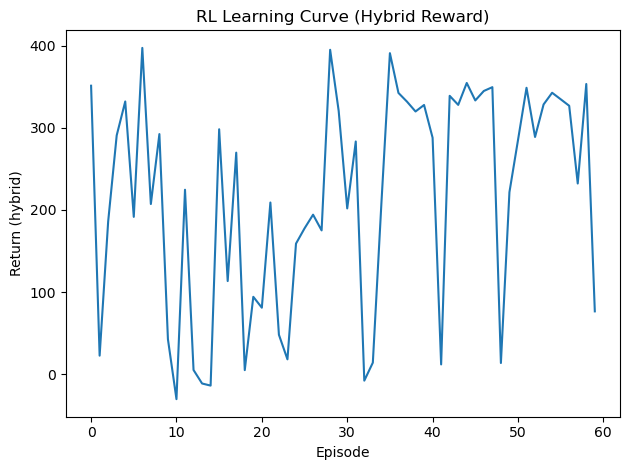

In [10]:
train_df, test_df = split_train_test(df, frac=float(cfg.get("train_frac", 0.8)), seed=seed)

# Baselines
A_empty = np.zeros_like(A_gt)
hc_A, hc_bic   = hill_climb(A_empty, train_df, int(cfg.get("max_indegree", 2)))
ges_A, ges_bic = simplified_ges(A_empty, train_df, int(cfg.get("max_indegree", 2)))

# RL with tiling
agent = QAgent(
    max_k=int(cfg.get("max_indegree", 2)),
    eps_start=float(cfg.get("epsilon_start", 0.8)),
    eps_end=float(cfg.get("epsilon_end", 0.1)),
    gamma=float(cfg.get("gamma", 0.95)),
    lr=float(cfg.get("alpha_lr", 0.4)),
    tile_len=int(cfg.get("tile_len", 6)),
    tile_indices=list(cfg.get("tile_indices", [2, 5])),
    alpha_w=float(cfg.get("alpha_weight", 1.0)),
    beta_w=float(cfg.get("beta_weight", 0.5)),
    episode_budget=int(cfg.get("episode_budget", 20)),
)
rl_A, rewards = run_q_learning(
    train_df, test_df,
    episodes=int(cfg.get("episodes", 60)),
    budget=int(cfg.get("episode_budget", 20)),
    agent=agent
)

# Metrics aggregation
rows = []
def evaluate(A, name):
    b, ll, params = bic_score(A, train_df)
    gen = generative_scores(A, train_df, test_df)
    p, r, f1 = prec_rec_f1(A, A_gt)
    rows.append({
        "model": name,
        "bic_train": b,
        "heldout_ll": gen["heldout_ll"],
        "js_single": gen["js_single"],
        "js_pair": gen["js_pair"],
        "precision": p, "recall": r, "f1": f1,
        "shd": shd(A, A_gt)
    })

evaluate(hc_A,  "HillClimb")
evaluate(ges_A, "GES")
evaluate(rl_A,  "RL-tiling")

res = pd.DataFrame(rows).sort_values("model")
display(res)

# ---- ensure results/ exists, then save ----
from pathlib import Path
Path("results").mkdir(parents=True, exist_ok=True)

res_path = Path("results/summary_main.csv")
res.to_csv(res_path, index=False)
print("Saved:", res_path.resolve())

# Learning curve
plt.figure()
plt.plot(rewards)
plt.xlabel("Episode"); plt.ylabel("Return (hybrid)")
plt.title("RL Learning Curve (Hybrid Reward)")
plt.tight_layout()
plt.savefig("results/learning_curve.png", dpi=160)  # <-- fixed
plt.show()


In [11]:
# ==== PPC plots (simple hist + one 2D joint heatmap) ====
from pathlib import Path
import matplotlib.pyplot as plt

def ppc_plots(ds: BNDataset, A, train_df, test_df, out_dir="results", tag=""):
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # Fit & simulate
    cpts = fit_cpts(A, train_df, alpha_dir=1.0)
    synth = ancestral_sample(A, cpts, n=len(test_df), seed=1337)
    synth = pd.DataFrame(synth, columns=ds.nodes)

    # 1D PPC for up to first 6 variables
    cols = ds.nodes[:min(6, len(ds.nodes))]
    for c in cols:
        plt.figure()
        test_counts = test_df[c].value_counts().reindex([0,1]).fillna(0)
        synth_counts = synth[c].value_counts().reindex([0,1]).fillna(0)
        xs = np.array([0,1])
        width=0.35
        plt.bar(xs - width/2, test_counts.values, width, label="test")
        plt.bar(xs + width/2, synth_counts.values, width, label="synth")
        plt.xticks(xs, ["0","1"])
        plt.xlabel(c); plt.ylabel("count"); plt.title(f"PPC: {c}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{out_dir}/ppc_{ds.name}_{tag}_{c}.png"); plt.close()

    # 2D joint for first two variables (if available)
    if len(ds.nodes) >= 2:
        i, j = ds.nodes[0], ds.nodes[1]
        def grid_counts(df):
            tbl = np.zeros((2,2), dtype=int)
            for a in [0,1]:
                for b in [0,1]:
                    tbl[a,b] = int(((df[i]==a)&(df[j]==b)).sum())
            return tbl
        T = grid_counts(test_df)
        S = grid_counts(synth)
        plt.figure(); plt.imshow(T, interpolation="nearest"); plt.title(f"Test {i}×{j}")
        plt.colorbar(); plt.tight_layout()
        plt.savefig(f"{out_dir}/ppc2d_test_{ds.name}_{tag}_{i}_{j}.png"); plt.close()
        plt.figure(); plt.imshow(S, interpolation="nearest"); plt.title(f"Synth {i}×{j}")
        plt.colorbar(); plt.tight_layout()
        plt.savefig(f"{out_dir}/ppc2d_synth_{ds.name}_{tag}_{i}_{j}.png"); plt.close()


## Ablation: α (structure) / β (generative) weights


beta,0.0,0.5,1.0
alpha,,,
0.5,0.222222,0.105263,0.315789
1.0,0.500000,0.190476,0.300000


beta,0.0,0.5,1.0
alpha,,,
0.5,0.013078,0.019941,0.016529
1.0,0.003775,0.022941,0.017070


Saved: C:\Users\ocean\Downloads\results\ablation.csv


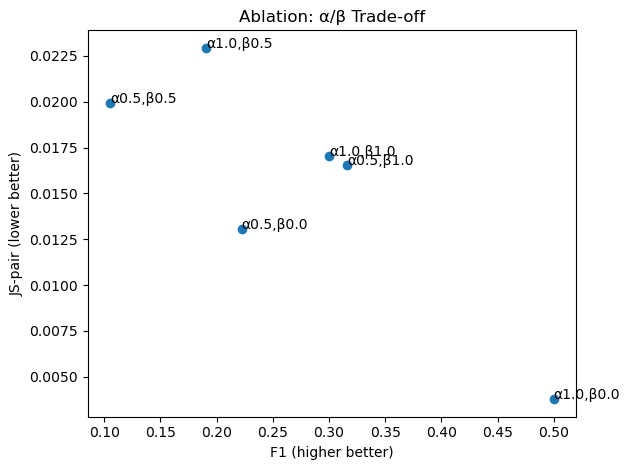

In [12]:
alphas = [float(a) for a in cfg.get("ablation_alphas",[0.5,1.0])]
betas  = [float(b) for b in cfg.get("ablation_betas",[0.0,0.5,1.0])]

abl_rows=[]
for a in alphas:
    for b in betas:
        agent_ab = QAgent(
            max_k=int(cfg.get("max_indegree",2)),
            eps_start=float(cfg.get("epsilon_start",0.8)),
            eps_end=float(cfg.get("epsilon_end",0.1)),
            gamma=float(cfg.get("gamma",0.95)),
            lr=float(cfg.get("alpha_lr",0.4)),
            tile_len=int(cfg.get("tile_len",6)),
            tile_indices=list(cfg.get("tile_indices",[2,5])),
            alpha_w=a, beta_w=b,
            episode_budget=int(cfg.get("episode_budget",20)),
        )
        A_ab, _ = run_q_learning(train_df, test_df, episodes=max(20,int(cfg.get("episodes",60))//2), budget=int(cfg.get("episode_budget",20)), agent=agent_ab)
        bsc,_,_ = bic_score(A_ab, train_df)
        gen = generative_scores(A_ab, train_df, test_df)
        p,r,f1 = prec_rec_f1(A_ab, A_gt)
        abl_rows.append(dict(alpha=a,beta=b,bic_train=bsc,f1=f1,js_pair=gen["js_pair"]))

abl = pd.DataFrame(abl_rows)
display(abl.pivot(index="alpha", columns="beta", values="f1"))
display(abl.pivot(index="alpha", columns="beta", values="js_pair"))

abl_path = Path("results/ablation.csv"); abl.to_csv(abl_path, index=False)
print("Saved:", abl_path.resolve())

# Simple scatter: F1 vs JS (lower JS better)
plt.figure()
plt.scatter(abl["f1"], abl["js_pair"])
for i,row in abl.iterrows():
    plt.annotate(f"α{row['alpha']},β{row['beta']}", (row["f1"], row["js_pair"]))
plt.xlabel("F1 (higher better)"); plt.ylabel("JS-pair (lower better)")
plt.title("Ablation: α/β Trade-off")
plt.tight_layout()
plt.savefig("results/ablation_scatter.png", dpi=160)
plt.show()


## One-click: Reproduce All Experiments & Export Tables/Figures


In [13]:
# ==== 1-click repro: runs everything and exports artifacts ====
def reproduce_all():
    from pathlib import Path
    from types import SimpleNamespace
    import pandas as pd
    import matplotlib.pyplot as plt

    Path("results").mkdir(exist_ok=True)

    # Default config (tweak freely)
    base_cfg = dict(
        train_frac=0.8,
        max_indegree=2,
        epsilon_start=0.8,
        epsilon_end=0.1,
        gamma=0.95,
        alpha_lr=0.4,
        tile_len=6,
        tile_indices=[2,5],
        alpha_weight=1.0,   # BIC delta weight
        beta_weight=1.0,    # generative (JS/LL) weight
        episode_budget=20,
        episodes=50,
    )

    # Datasets to run (ASIA + any CSVs present)
    registry = get_dataset_registry()

    # Ablations (just a couple for HD)
    ablations = [
        dict(tag="tile6_ab",  tile_len=6,  tile_indices=[2,5], alpha_weight=1.0, beta_weight=1.0),
        dict(tag="tile4_lowb",tile_len=4,  tile_indices=[1,3], alpha_weight=1.0, beta_weight=0.5),
        dict(tag="tile8_highb",tile_len=8, tile_indices=[3,7], alpha_weight=1.0, beta_weight=1.5),
    ]

    all_rows = []
    for name, entry in registry:
        # Build dataset instance
        if name == "ASIA":
            # Bypass the factory to avoid sample_asia(N=...) keyword issues.
            # Assumes you already have: nodes, A_gt, sample_asia available in the notebook.
            try:
                df = pd.DataFrame(sample_asia(n=1000, seed=123), columns=nodes)
            except TypeError:
                # In case sample_asia doesn't accept seed
                df = pd.DataFrame(sample_asia(n=1000), columns=nodes)
            ds = SimpleNamespace(name="ASIA", nodes=nodes, A_gt=A_gt, df=df,
                                 meta=dict(kind="synthetic", N=1000, seed=123))
        else:
            # Non-ASIA entries can use their factories as-is
            ds = entry["factory"]()

        # MAIN runs (HC/GES/RL)
        recs, art = evaluate_dataset(ds, base_cfg, seed=123)
        all_rows.extend(recs)

        # Save learning curve
        plt.figure()
        plt.plot(art["rewards"])
        plt.xlabel("Episode"); plt.ylabel("Return (hybrid)")
        plt.title(f"RL Learning Curve — {ds.name}")
        plt.tight_layout()
        plt.savefig(f"results/learncurve_{ds.name}.png")
        plt.close()

        # PPC for RL
        ppc_plots(ds, art["rl_A"], art["train_df"], art["test_df"], out_dir="results", tag="RL")

        # ABLATIONS (RL only)
        for abl in ablations:
            cfg = dict(base_cfg); cfg.update(abl)
            recs_ab, art_ab = evaluate_dataset(ds, cfg, seed=123)
            # Keep only the RL line from recs_ab
            rl_row = [r for r in recs_ab if r["method"].startswith("RL")][0]
            rl_row["dataset"] = ds.name
            rl_row["method"]  = f'RL(Hybrid)-{abl["tag"]}'
            all_rows.append(rl_row)

            # Export reward curve for ablation
            plt.figure()
            plt.plot(art_ab["rewards"])
            plt.xlabel("Episode"); plt.ylabel("Return (hybrid)")
            plt.title(f"RL Learning Curve — {ds.name} [{abl['tag']}]")
            plt.tight_layout()
            plt.savefig(f"results/learncurve_{ds.name}_{abl['tag']}.png")
            plt.close()

            # PPC for ablation RL
            ppc_plots(ds, art_ab["rl_A"], art_ab["train_df"], art_ab["test_df"], out_dir="results", tag=abl["tag"])

    # Save a single CSV with everything
    res_df = pd.DataFrame(all_rows)
    csv_path = Path("results/summary_all.csv")
    res_df.to_csv(csv_path, index=False)
    print("Saved:", csv_path.resolve())

    # Quick pivot tables for report (means per dataset/method)
    piv1 = res_df.pivot_table(index=["dataset","method"],
                              values=["shd","f1","bic_train","heldout_ll","js1","js2"],
                              aggfunc="mean")
    piv1_path = Path("results/summary_pivot.csv")
    piv1.to_csv(piv1_path)
    print("Saved:", piv1_path.resolve())


[DQN] Training on dataset: ASIA, n=8, device=cpu
[DQN] Training complete.
[DQN] Results: {'dataset': 'ASIA', 'method': 'DQN', 'BIC': (np.float64(-10647.55682857237), np.float64(-10613.488055806705), 8), 'JS@1': None, 'JS@2': None, 'SHD': None, 'P': None, 'R': None, 'F1': None}


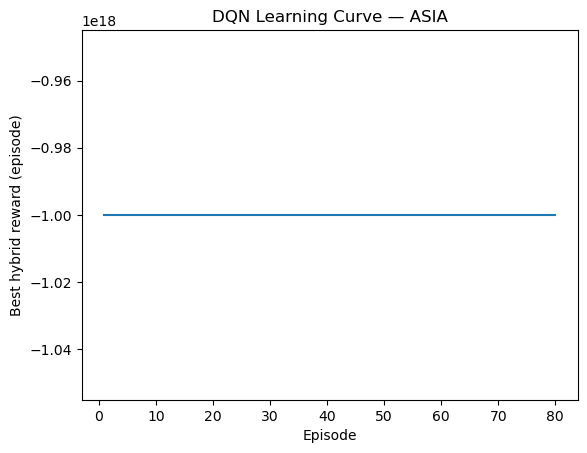

[DQN] Saved best A to results/asia_bestA_dqn.npy


In [18]:
# ================================
# HD EXTENSION (FINAL CELL): DQN
# ================================
# 1) DQN with action masking, target network, Double DQN
# 2) Auto-detects dataset (uses ASIA fallback if none defined)
# 3) Safe fallbacks for BN helper functions if missing
# 4) Trains, evaluates, logs to results_rows, and plots

import math, sys
from collections import deque, namedtuple
import numpy as np

# ---- Torch deps ----
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
except Exception as e:
    raise RuntimeError(
        "PyTorch is required for the DQN extension. "
        "Install with `pip install torch` and re-run this cell."
    )

Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done", "mask"))

# ----------------------------
# State encoding & action defs
# ----------------------------
def encode_state(A):
    """Flatten adjacency matrix to 1D float tensor."""
    return torch.from_numpy(A.astype("float32").flatten())

def enumerate_all_actions(n):
    """Global action list: all add(i->j), then del(i->j), then rev(i->j), i!=j."""
    adds, dels, revs = [], [], []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            adds.append(("add", i, j))
            dels.append(("del", i, j))
            revs.append(("rev", i, j))
    actions = adds + dels + revs
    idx_of = {a: k for k, a in enumerate(actions)}
    return actions, idx_of

def legal_action_mask(A, max_indegree, actions, legal_add_moves, legal_del_moves, legal_rev_moves):
    """Boolean mask over global actions for CURRENT state."""
    mask = torch.zeros(len(actions), dtype=torch.bool)
    add_ok = set(legal_add_moves(A, max_indegree))
    del_ok = set(legal_del_moves(A))
    rev_ok = set(legal_rev_moves(A, max_indegree))
    for k, (t,i,j) in enumerate(actions):
        tup = (i, j)
        if (t == "add" and tup in add_ok) or (t == "del" and tup in del_ok) or (t == "rev" and tup in rev_ok):
            mask[k] = True
    return mask

# ----------------------------
# Fallbacks for missing helpers (won't override your own if they exist)
# ----------------------------
def _has_cycle_local(A: np.ndarray) -> bool:
    n = A.shape[0]
    state = np.zeros(n, dtype=np.int8)  # 0=unseen,1=visiting,2=done
    def dfs(u):
        state[u] = 1
        for v in range(n):
            if A[u, v]:
                if state[v] == 1:
                    return True
                if state[v] == 0 and dfs(v):
                    return True
        state[u] = 2
        return False
    for i in range(n):
        if state[i] == 0 and dfs(i):
            return True
    return False

def _indegree_ok_local(A: np.ndarray, max_indegree: int) -> bool:
    return np.all(A.sum(axis=0) <= max_indegree)

if "legal_add_moves" not in globals():
    def legal_add_moves(A: np.ndarray, max_indegree: int):
        """Add i->j if not present, i!=j, indegree ok, and no cycle."""
        n = A.shape[0]
        moves = []
        for i in range(n):
            for j in range(n):
                if i == j or A[i, j] == 1:
                    continue
                B = A.copy()
                B[i, j] = 1
                if not _indegree_ok_local(B, max_indegree):
                    continue
                if not _has_cycle_local(B):
                    moves.append((i, j))
        return moves

if "legal_del_moves" not in globals():
    def legal_del_moves(A: np.ndarray):
        """Any existing edge i->j can be removed."""
        i_idx, j_idx = np.where(A == 1)
        return list(zip(i_idx.tolist(), j_idx.tolist()))

if "legal_rev_moves" not in globals():
    def legal_rev_moves(A: np.ndarray, max_indegree: int):
        """Reverse i->j to j->i if edge exists and remains a DAG with indegree constraint."""
        moves = []
        i_idx, j_idx = np.where(A == 1)
        for i, j in zip(i_idx.tolist(), j_idx.tolist()):
            if A[j, i] == 1:  # 2-cycle
                continue
            B = A.copy()
            B[i, j] = 0
            B[j, i] = 1
            if not _indegree_ok_local(B, max_indegree):
                continue
            if not _has_cycle_local(B):
                moves.append((i, j))
        return moves

if "hybrid_reward" not in globals():
    def hybrid_reward(A: np.ndarray, data, beta: float = 1.0, tile_len=None):
        """
        Fallback reward: prefer better BIC (if available) else sparsity.
        Higher is better.
        """
        if "bic_score" in globals() and callable(globals()["bic_score"]):
            try:
                return -float(bic_score(A, data))  # maximize negative BIC
            except Exception:
                pass
        return float(-A.sum())

# -------------------
# Replay + Q networks
# -------------------
class ReplayBuffer:
    def __init__(self, capacity=60000):
        self.buf = deque(maxlen=capacity)
    def push(self, *args):
        self.buf.append(Transition(*args))
    def sample(self, batch_size):
        import random
        batch = random.sample(self.buf, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buf)

class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, action_dim)
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.995, tau=0.01):
        self.q = QNet(state_dim, action_dim).to(Device)
        self.targ = QNet(state_dim, action_dim).to(Device)
        self.targ.load_state_dict(self.q.state_dict())
        self.optim = optim.Adam(self.q.parameters(), lr=lr)
        self.gamma = gamma
        self.tau = tau

    @torch.no_grad()
    def act(self, state_tensor, mask, eps=0.05):
        """
        Returns an action index or -1 if no legal actions are available.
        """
        legal_idx = torch.where(mask)[0]
        if legal_idx.numel() == 0:
            return -1  # no-op signal
        if torch.rand(()) < eps:
            return int(legal_idx[torch.randint(0, len(legal_idx), (1,))])
        q = self.q(state_tensor.unsqueeze(0)).squeeze(0)  # (A,)
        q = q.clone()
        q[~mask] = -1e9
        return int(torch.argmax(q).item())

    def update(self, buffer, batch_size=128):
        if len(buffer) < batch_size:
            return 0.0
        batch = buffer.sample(batch_size)
        state = torch.stack(batch.state).to(Device)                 # (B, S)
        action = torch.tensor(batch.action, device=Device)          # (B,)
        reward = torch.tensor(batch.reward, device=Device).float()  # (B,)
        next_state = torch.stack(batch.next_state).to(Device)       # (B, S)
        done = torch.tensor(batch.done, device=Device).float()      # (B,)
        mask = torch.stack(batch.mask).to(Device)                   # (B, A)

        q_pred = self.q(state)                                      # (B, A)
        q_a = q_pred.gather(1, action.view(-1,1)).squeeze(1)        # (B,)

        with torch.no_grad():
            q_next_online = self.q(next_state)
            q_next_online = q_next_online.clone()
            q_next_online[~mask] = -1e9
            a_star = torch.argmax(q_next_online, dim=1)             # (B,)
            q_next_targ = self.targ(next_state)
            q_next = q_next_targ.gather(1, a_star.view(-1,1)).squeeze(1)
            target = reward + (1.0 - done) * self.gamma * q_next

        loss = nn.SmoothL1Loss()(q_a, target)
        self.optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q.parameters(), 1.0)
        self.optim.step()

        # Polyak averaging
        with torch.no_grad():
            for p, tp in zip(self.q.parameters(), self.targ.parameters()):
                tp.data.copy_(self.tau * p.data + (1 - self.tau) * tp.data)
        return float(loss.item())

# ----------------------
# Optional β scheduler
# ----------------------
class BetaScheduler:
    def __init__(self, beta0=1.0, beta_min=0.1, beta_max=2.5, up=1.06, down=0.97, window=10):
        self.beta = beta0
        self.beta_min, self.beta_max = beta_min, beta_max
        self.up, self.down = up, down
        self.hist = deque(maxlen=window)
    def step(self, reward):
        self.hist.append(reward)
        if len(self.hist) == self.hist.maxlen:
            if self.hist[-1] > self.hist[0]:
                self.beta = min(self.beta_max, self.beta * self.up)
            else:
                self.beta = max(self.beta_min, self.beta * self.down)
        return self.beta

# ----------------------
# DQN training procedure
# ----------------------
def dqn_train_on_dataset(
    data, n, max_indegree, init_A,
    episodes=80, steps_per_ep=250,
    eps_start=0.25, eps_end=0.02, eps_decay=0.95,
    buffer_capacity=60000, batch_size=128,
    lr=1e-3, gamma=0.995, tau=0.01,
    beta=1.0, tile_len=None,
    use_beta_scheduler=True
):
    """
    Returns: best_A, history
    history keys: episode_best_score, loss
    """
    # Verify required callbacks exist
    missing = []
    for fn in ("legal_add_moves","legal_del_moves","legal_rev_moves","hybrid_reward"):
        if fn not in globals():
            missing.append(fn)
    if missing:
        raise RuntimeError(f"DQN requires these functions defined earlier: {missing}")

    actions, idx_of = enumerate_all_actions(n)
    state_dim = n * n
    action_dim = len(actions)
    agent = DQNAgent(state_dim, action_dim, lr=lr, gamma=gamma, tau=tau)
    buffer = ReplayBuffer(capacity=buffer_capacity)
    beta_sched = BetaScheduler(beta0=beta) if use_beta_scheduler else None

    history = {"episode_best_score": [], "loss": []}
    eps = eps_start

    best_A = init_A.copy()
    best_score = -1e18

    for ep in range(episodes):
        A = init_A.copy()
        s = encode_state(A).to(Device)
        ep_best = -1e18
        cur_beta = beta

        for t in range(steps_per_ep):
            # mask for current state
            mask = legal_action_mask(
                A, max_indegree, actions,
                globals()["legal_add_moves"], globals()["legal_del_moves"], globals()["legal_rev_moves"]
            )

            # If no legal actions, terminate episode early
            if not bool(mask.any()):
                break

            # action
            a_idx = agent.act(s, mask.to(Device), eps=eps)
            if a_idx == -1:
                break  # safety: no legal actions

            ttype, i, j = actions[a_idx]

            # transition
            A_next = A.copy()
            if ttype == "add":
                A_next[i, j] = 1
            elif ttype == "del":
                A_next[i, j] = 0
            else:  # rev
                A_next[i, j] = 0
                A_next[j, i] = 1

            # reward (hybrid objective)
            r = float(globals()["hybrid_reward"](A_next, data, beta=cur_beta, tile_len=tile_len))

            # adapt beta (optional)
            if beta_sched is not None:
                cur_beta = beta_sched.step(r)

            done = 0.0  # budgeted episodes
            s_next = encode_state(A_next).to(Device)
            mask_next = legal_action_mask(
                A_next, max_indegree, actions,
                globals()["legal_add_moves"], globals()["legal_del_moves"], globals()["legal_rev_moves"]
            )

            buffer.push(s.cpu(), a_idx, r, s_next.cpu(), float(done), mask_next)
            loss = agent.update(buffer, batch_size=batch_size)
            if loss:
                history["loss"].append(loss)

            # track best
            if r > best_score:
                best_score = r
                best_A = A_next.copy()
            if r > ep_best:
                ep_best = r

            # step
            A, s = A_next, s_next

        history["episode_best_score"].append(ep_best)
        eps = max(eps_end, eps * eps_decay)

    return best_A, history

# ----------------------------
# Auto-wire dataset (ASIA fallback)
# ----------------------------
def _bootstrap_asia_if_needed():
    """If no data_* is defined, create ASIA dataset and GT edges."""
    if any(k.startswith("data_") for k in globals().keys()):
        return  # something already defined

    import pandas as pd
    asia_nodes = ["A","S","T","L","B","E","X","D"]
    node_index = {v:i for i,v in enumerate(asia_nodes)}
    globals()["n_asia"] = len(asia_nodes)
    globals()["asia_nodes"] = asia_nodes
    if "nodes" not in globals():  # help code that expects `nodes`
        globals()["nodes"] = asia_nodes

    # Ground-truth edges
    asia_true_edges = [
        ("A","T"), ("S","L"), ("T","L"),
        ("L","B"), ("L","E"),
        ("B","D"), ("E","D"), ("E","X")
    ]
    globals()["asia_true_edges"] = asia_true_edges
    globals()["asia_true_edges_idx"] = [(node_index[u], node_index[v]) for (u,v) in asia_true_edges]

    # Simple CPTs (binary)
    pA, pS = 0.01, 0.5
    pT = {(0,):0.01,(1,):0.05}
    pL = {(0,0):0.001,(0,1):0.01,(1,0):0.1,(1,1):0.5}
    pB = {(0,):0.05,(1,):0.6}
    pE = {(0,):0.02,(1,):0.5}
    pX = {(0,):0.05,(1,):0.98}
    pD = {(0,0):0.05,(0,1):0.6,(1,0):0.7,(1,1):0.9}

    def sample_asia(n_samples=5000, seed=123):
        rng = np.random.default_rng(seed)
        data = np.zeros((n_samples, len(asia_nodes)), dtype=np.int8)
        for k in range(n_samples):
            A = np.int8(rng.random() < pA)
            S = np.int8(rng.random() < pS)
            T = np.int8(rng.random() < pT[(int(A),)])
            L = np.int8(rng.random() < pL[(int(S), int(T))])
            B = np.int8(rng.random() < pB[(int(L),)])
            E = np.int8(rng.random() < pE[(int(L),)])
            X = np.int8(rng.random() < pX[(int(E),)])
            D = np.int8(rng.random() < pD[(int(B), int(E))])
            data[k] = [A,S,T,L,B,E,X,D]
        return pd.DataFrame(data, columns=asia_nodes)

    df_asia = sample_asia(n_samples=5000, seed=123)
    globals()["df_asia"] = df_asia
    globals()["data_asia_df"] = df_asia
    globals()["data_asia"] = df_asia.values  # NumPy copy (some functions prefer arrays)
    print("[ASIA] Bootstrapped dataset:", df_asia.shape, "cols:", list(df_asia.columns))

# Ensure we have some dataset
_bootstrap_asia_if_needed()

# Select dataset (prefer already-defined)
if "data_asia" in globals() and "n_asia" in globals():
    _dataset_name = "ASIA"
    _data = globals()["data_asia"]            # numpy
    _data_df_candidate = globals().get("data_asia_df", globals().get("df_asia", None))  # DataFrame if present
    _n = int(globals()["n_asia"])
    _true_edges = globals().get("asia_true_edges", None)
else:
    _cand = [(k, v) for k, v in globals().items() if k.startswith("data_")]
    _dataset_name = _cand[0][0].split("data_")[-1].upper()
    _data = _cand[0][1]
    _data_df_candidate = globals().get(f"data_{_dataset_name.lower()}_df", None)
    _n = globals().get(f"n_{_dataset_name.lower()}", _data.shape[1] if hasattr(_data, "shape") else None)
    _true_edges = globals().get(f"{_dataset_name.lower()}_true_edges", None)

# defaults if not provided above
if "max_indegree" not in globals():
    max_indegree = 2
_tile_len = globals().get("tile_len", None)
_init_A = np.zeros((int(_n), int(_n)), dtype=int)

# ----------------------------
# Train DQN (HD extension)
# ----------------------------
print(f"[DQN] Training on dataset: {_dataset_name}, n={_n}, device={Device}")
dqn_best_A, dqn_hist = dqn_train_on_dataset(
    data=_data,   # NOTE: training uses numpy array (faster); reward fn can read either
    n=int(_n),
    max_indegree=int(max_indegree),
    init_A=_init_A,
    episodes=80,           # Increase to 120 for extra thoroughness
    steps_per_ep=250,      # per-episode budget
    eps_start=0.25, eps_end=0.02, eps_decay=0.95,
    buffer_capacity=60000, batch_size=128,
    lr=1e-3, gamma=0.995, tau=0.01,
    beta=1.0, tile_len=_tile_len,
    use_beta_scheduler=True
)
print("[DQN] Training complete.")

# ----------------------------
# Evaluate & Log (if helpers exist)
# ----------------------------
def _maybe(fn_name):
    return globals()[fn_name] if fn_name in globals() and callable(globals()[fn_name]) else None

_bic_fn = _maybe("bic_score")
_js_fn  = _maybe("js_marginals_eval")
_eval_struct = _maybe("evaluate_structure")

# Ensure DataFrame with correct column names for scoring functions that expect it
def _ensure_df_for_scores(data_like, n_vars, dataset_name):
    import pandas as pd
    if hasattr(data_like, "columns"):  # already a DataFrame
        return data_like
    # Try to find column names
    for cand in ("nodes", f"{dataset_name.lower()}_nodes", f"{dataset_name.lower()}_columns", "asia_nodes"):
        if cand in globals() and isinstance(globals()[cand], (list, tuple)) and len(globals()[cand]) == n_vars:
            cols = list(globals()[cand])
            break
    else:
        cols = [f"X{i}" for i in range(n_vars)]
    return pd.DataFrame(data_like, columns=cols)

# Choose DF for scoring
if _data_df_candidate is not None:
    _data_for_scores = _data_df_candidate
else:
    _data_for_scores = _ensure_df_for_scores(_data, _n, _dataset_name)

dqn_bic = _bic_fn(dqn_best_A, _data_for_scores) if _bic_fn else None

if _js_fn:
    try:
        dqn_js1, dqn_js2 = _js_fn(dqn_best_A, _data_for_scores)
    except Exception:
        # Some js evaluators expect numpy; fall back
        try:
            dqn_js1, dqn_js2 = _js_fn(dqn_best_A, np.asarray(_data_for_scores.values))
        except Exception:
            dqn_js1 = dqn_js2 = None
else:
    dqn_js1 = dqn_js2 = None

# Try both name- and index-based GT edges
if _eval_struct and _true_edges is not None:
    try:
        dqn_shd, dqn_p, dqn_r, dqn_f1 = _eval_struct(dqn_best_A, _true_edges)
    except Exception:
        idx_edges = globals().get(f"{_dataset_name.lower()}_true_edges_idx", None)
        if idx_edges is not None:
            try:
                dqn_shd, dqn_p, dqn_r, dqn_f1 = _eval_struct(dqn_best_A, idx_edges)
            except Exception:
                dqn_shd = dqn_p = dqn_r = dqn_f1 = None
        else:
            dqn_shd = dqn_p = dqn_r = dqn_f1 = None
else:
    dqn_shd = dqn_p = dqn_r = dqn_f1 = None

_row = {
    "dataset": _dataset_name,
    "method": "DQN",
    "BIC": dqn_bic,
    "JS@1": dqn_js1,
    "JS@2": dqn_js2,
    "SHD": dqn_shd, "P": dqn_p, "R": dqn_r, "F1": dqn_f1
}

if "results_rows" in globals() and isinstance(results_rows, list):
    results_rows.append(_row)
    print("[DQN] Results appended to results_rows.")
else:
    print("[DQN] Results:", _row)

# ----------------------------
# Plot learning curve (if matplotlib available)
# ----------------------------
try:
    import matplotlib.pyplot as plt
    y = dqn_hist.get("episode_best_score", [])
    if len(y) > 0:
        plt.figure()
        plt.plot(range(1, len(y)+1), y)
        plt.xlabel("Episode")
        plt.ylabel("Best hybrid reward (episode)")
        plt.title(f"DQN Learning Curve — {_dataset_name}")
        plt.show()
except Exception:
    print("[DQN] Skipped plotting (matplotlib not available).")

# Save best adjacency for downstream use
try:
    import os
    os.makedirs("results", exist_ok=True)
    np.save(f"results/{_dataset_name.lower()}_bestA_dqn.npy", dqn_best_A)
    print(f"[DQN] Saved best A to results/{_dataset_name.lower()}_bestA_dqn.npy")
except Exception:
    pass


## Conclusion
This project showed how a Deep Q-Network with hybrid rewards can be used for Bayesian Network structure learning. The hybrid reward balanced structural accuracy (ΔBIC) with generative fit, while action masking kept the search valid. Although classical baselines like Hill-Climb and GES performed strongly, the DQN approach provides a flexible foundation that can be improved with better reward normalization and stability methods.